#***Задача прогнозирования минимального баланса клиентов банка***

Цель проекта - предсказать, какие клиенты банка сохранят положительный баланс на своих счетах. Банк заинтересован в том, чтобы клиенты поддерживали ненулевой остаток на картах, так как обнуление баланса является нежелательным исходом.

*Исходные данные включают:*

1) Массив транзакций за трехмесячный период (более 13.5 миллионов операций)

2) Информацию по более чем 100 тысячам клиентов

3) Целевую переменную, отражающую группу минимального баланса на следующий месяц (шкала от 0 до 7)

*Ключевые характеристики:*

1) Классификация клиентов происходит на основе их минимального баланса в последующем месяце

2) Существует прямая зависимость между номером группы и размером минимального баланса

3) Основной фокус направлен на выявление клиентов с высоким риском снижения остатка до минимальных значений

In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import  mean_absolute_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
from datetime import date
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def fit_catboost_classifier(features_train, target_train, features_val=None, target_val=None, cat_features=None, params=None):
    default_params = {'learning_rate': 0.01, 'iterations': 2550} # 'auto_class_weights': 'Balanced'   "class_weights": cw
    if params is None:
        params = default_params

    if cat_features is None:
      pool_train = Pool(features_train, target_train)
    else:
      pool_train = Pool(features_train, target_train, cat_features = cat_features)
    pool_val = None
    if features_val is not None:
      if cat_features is None:
        pool_val = Pool(features_val, target_val)
      else:
        pool_val = Pool(features_val, target_val, cat_features = cat_features)

    if 'loss_function' not in params:
      params['loss_function'] = 'MultiClass'

    model = CatBoostClassifier(**params, random_seed = 42, task_type="CPU")
    model.fit(pool_train, eval_set=pool_val, verbose=500, early_stopping_rounds=100)
    return model

In [ ]:
# Чтение данных
df_transaction = pd.read_parquet('df_transaction.pa')
train = pd.read_parquet('train.pa')

### Просмотр данных

In [ ]:
train.head()

,client_num,target
0,94779,3
1,17279,0
2,5717,2
3,27471,1
4,72725,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   client_num  70000 non-null  int64
 1   target      70000 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


In [ ]:
df_transaction.head()

,client_num,date_time,mcc_code,merchant_name,amount
0,0,2024-07-18 16:04:00,8099,a011100358d0f73ea8f3e860ef5564e3ba9cb217b7b90c...,2900
1,0,2024-07-22 16:31:00,5411,f3855606fc7244ec2f37ea01a4b2b66933d0e965bf4aec...,455
2,0,2024-07-24 16:23:00,5541,786270fa33ad4ac2a3c0e52e888005aa7f98beadbf8986...,1003
3,0,2024-07-28 15:51:00,5691,54887ad4a8df7e260a3ac85e59128a947c50d4423f6330...,1480
4,0,2024-07-28 18:00:00,5331,21617559a372c7cca155208c87be6c84ce97b5f8775589...,88


* client_num - номер клиента
* date_time - время транзакции
* mcc_code - МСС код
* merchant_name - хеш имени мерчанта
* amount - сумма транзакции

In [ ]:
df_transaction.shape

(13508155, 5)

In [ ]:
df_transaction.describe()

,client_num,date_time,amount
count,1.350816e+07,13508155,1.350816e+07
mean,3.880260e+04,2024-08-16 14:05:54.827905,2.341709e+03
min,0.000000e+00,2024-07-01 00:00:00,0.000000e+00
25%,1.550000e+04,2024-07-24 15:19:00,1.230000e+02
50%,3.418100e+04,2024-08-16 20:12:00,3.150000e+02
75%,5.827800e+04,2024-09-08 14:21:00,8.200000e+02
max,1.091420e+05,2024-10-01 00:00:00,8.680000e+06
std,2.741952e+04,NaN,2.292657e+04


In [ ]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13508155 entries, 0 to 13508154
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   client_num     int64         
 1   date_time      datetime64[us]
 2   mcc_code       object        
 3   merchant_name  object        
 4   amount         int64         
dtypes: datetime64[us](1), int64(2), object(2)
memory usage: 515.3+ MB


In [ ]:
train.groupby(by=['target'], as_index=False).count()

,target,client_num
0,0,15091
1,1,18020
2,2,9873
3,3,7987
4,4,8034
5,5,5507
6,6,5488


In [ ]:
train['client_num'].nunique(), df_transaction['client_num'].nunique()

(70000, 109143)

In [ ]:
df_transaction['date_time'].min(), df_transaction['date_time'].max()

(Timestamp('2024-07-01 00:00:00'), Timestamp('2024-10-01 00:00:00'))

In [ ]:
# Количество дней по клиентам
# среднее, медиана, минимальное, максимальное
df_transaction.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].mean(), df_transaction.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].median(),df_transaction.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].min(),df_transaction.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].max()

(123.7656560658952, 87.0, 15, 3364)

In [ ]:
df_transaction.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'}).query('date_time == 3364')

,client_num,date_time
3467,3467,3364


In [ ]:
df_transaction.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'}).query('date_time == 15')

,client_num,date_time
1645,1645,15
2344,2344,15
3686,3686,15
4722,4722,15
5421,5421,15
...,...,...
109134,109134,15
109135,109135,15
109136,109136,15
109139,109139,15


In [ ]:
df_transaction.groupby(by=['client_num']).agg({'date_time': 'count'}).describe()

,date_time
count,109143.000000
mean,123.765656
std,116.615261
min,15.000000
25%,39.000000
50%,87.000000
75%,172.000000
max,3364.000000


### Объединение данных, выделение TRAIN и TEST наборов

In [ ]:
merge_data = df_transaction.merge(train, on='client_num', how='left')

In [ ]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13508155 entries, 0 to 13508154
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   client_num     int64         
 1   date_time      datetime64[us]
 2   mcc_code       object        
 3   merchant_name  object        
 4   amount         int64         
 5   target         float64       
dtypes: datetime64[us](1), float64(1), int64(2), object(2)
memory usage: 618.4+ MB


In [ ]:
merge_data['target'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 13508155 entries, 0 to 13508154
Series name: target
Non-Null Count    Dtype  
--------------    -----  
8679725 non-null  float64
dtypes: float64(1)
memory usage: 103.1 MB


In [ ]:
merge_data['target'].isnull().sum()/merge_data['target'].count()

0.5562883616704446

In [ ]:
merge_data['target'].isnull().sum()

4828430

In [ ]:
test_data = merge_data[merge_data['target'].isnull()]
test_data.describe()

,client_num,date_time,amount,target
count,4.828430e+06,4828430,4.828430e+06,0.0
mean,3.898150e+04,2024-08-16 13:57:21.577771,2.289532e+03,NaN
min,0.000000e+00,2024-07-01 00:00:00,0.000000e+00,NaN
25%,1.579200e+04,2024-07-24 15:03:00,1.230000e+02,NaN
50%,3.449800e+04,2024-08-16 19:58:00,3.150000e+02,NaN
75%,5.874200e+04,2024-09-08 14:29:00,8.190000e+02,NaN
max,1.091400e+05,2024-10-01 00:00:00,4.150000e+06,NaN
std,2.747363e+04,NaN,2.087185e+04,NaN


In [ ]:
train_data = merge_data[~merge_data['target'].isnull()]
train_data.describe()

,client_num,date_time,amount,target
count,8.679725e+06,8679725,8.679725e+06,8.679725e+06
mean,3.870308e+04,2024-08-16 14:10:40.342980,2.370734e+03,2.719290e+00
min,1.000000e+00,2024-07-01 00:00:00,0.000000e+00,0.000000e+00
25%,1.537000e+04,2024-07-24 15:26:00,1.240000e+02,1.000000e+00
50%,3.401200e+04,2024-08-16 20:20:00,3.150000e+02,3.000000e+00
75%,5.799000e+04,2024-09-08 14:16:00,8.200000e+02,4.000000e+00
max,1.091420e+05,2024-10-01 00:00:00,8.680000e+06,6.000000e+00
std,2.738887e+04,NaN,2.399349e+04,1.903645e+00


### Добавление временных признаков

In [ ]:
train_data['month_start'] = train_data['date_time'].apply(lambda x: date(x.year, x.month, 1))

In [ ]:
test_data['month_start'] = test_data['date_time'].apply(lambda x: date(x.year, x.month, 1))

In [ ]:
train_data['week'] = train_data['date_time'].apply(lambda x: x.week)
test_data['week'] = test_data['date_time'].apply(lambda x: x.week)

In [ ]:
train_data['transaction_date'] = train_data['date_time'].dt.date
test_data['transaction_date'] = test_data['date_time'].dt.date

### Просмотр train и test данных

In [ ]:
train_data.head(15)

,client_num,date_time,mcc_code,merchant_name,amount,target,month_start,week,transaction_date
132,1,2024-07-01 09:01:00,5541,84620a9333be55c5f41eb224fed1974200cc0983e33631...,4059,4.0,2024-07-01,27,2024-07-01
133,1,2024-07-01 16:57:00,5411,4829cd530ed1ec8bc8358740c2250f63ce5a42611cfa09...,444,4.0,2024-07-01,27,2024-07-01
134,1,2024-07-01 19:52:00,5200,c80805234182f4450be61e6f9605c1f16cc5c5be22a117...,5633,4.0,2024-07-01,27,2024-07-01
135,1,2024-07-01 20:11:00,5200,c80805234182f4450be61e6f9605c1f16cc5c5be22a117...,3009,4.0,2024-07-01,27,2024-07-01
136,1,2024-07-01 21:44:00,5411,f932e883f0c291aca1c74315b30ec799bf37b4eadfee14...,5481,4.0,2024-07-01,27,2024-07-01
137,1,2024-07-01 21:46:00,5921,3098b5e726dcf581d9e8ee3fdc3d2a50a7bab826cd431c...,114,4.0,2024-07-01,27,2024-07-01
138,1,2024-07-01 21:52:00,5411,973800fd535958f0b1a6e4c6d87bcbba7ca74740580e18...,247,4.0,2024-07-01,27,2024-07-01
139,1,2024-07-02 19:05:00,5411,cca508f38156aab4b55484dbce0bba39a9803fe93a73b6...,110,4.0,2024-07-01,27,2024-07-02
140,1,2024-07-02 19:34:00,6011,93d8aa062b09e903cdc2ffe87d269e93ddc8c481a19650...,100000,4.0,2024-07-01,27,2024-07-02
141,1,2024-07-02 20:39:00,5411,b2d34d7990716da0f2dccd724c646cfaf35f40c6755394...,13169,4.0,2024-07-01,27,2024-07-02


In [ ]:
train_data['client_num'].nunique(), test_data['client_num'].nunique()

(70000, 39143)

In [ ]:
# Количество дней по клиентам TRAIN
# среднее, медиана, минимальное, максимальное
train_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].mean(), train_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].median(),train_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].min(),train_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].max()

(123.99607142857143, 87.0, 15, 3364)

In [ ]:
# Количество дней по клиентам TEST
# среднее, медиана, минимальное, максимальное
test_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].mean(), test_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].median(),test_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].min(),test_data.groupby(by=['client_num'], as_index=False).agg({'date_time': 'count'})['date_time'].max()

(123.3536008992668, 86.0, 15, 2566)

In [ ]:
train_data['mcc_code'].nunique(), train_data['merchant_name'].nunique()

(315, 554268)

In [ ]:
train_data.groupby(by=['target'], as_index=False).count()

,target,client_num,date_time,mcc_code,merchant_name,amount,month_start,week,transaction_date
0,0.0,1229137,1229137,1229137,1229137,1229137,1229137,1229137,1229137
1,1.0,1743694,1743694,1743694,1743694,1743694,1743694,1743694,1743694
2,2.0,1189822,1189822,1189822,1189822,1189822,1189822,1189822,1189822
3,3.0,1233893,1233893,1233893,1233893,1233893,1233893,1233893,1233893
4,4.0,1484829,1484829,1484829,1484829,1484829,1484829,1484829,1484829
5,5.0,951747,951747,951747,951747,951747,951747,951747,951747
6,6.0,846603,846603,846603,846603,846603,846603,846603,846603


In [ ]:
train_data.groupby(by=['target', 'month_start'], as_index=False).agg({'amount': ['sum', 'min', 'max', 'median']})

target month_start      amount                     
                              sum  min      max median
0     0.0  2024-07-01  1010799450    0  1000000  320.0
1     0.0  2024-08-01  1029354339    0  1130000  335.0
2     0.0  2024-09-01   972215944    0  1000000  321.0
3     0.0  2024-10-01          64   64       64   64.0
4     1.0  2024-07-01  1013084952    0  1185000  261.0
5     1.0  2024-08-01  1067633634    0  1495000  265.0
6     1.0  2024-09-01  1001902024    0  1000000  243.0
7     1.0  2024-10-01          31   31       31   31.0
8     2.0  2024-07-01   715067504    0  1100000  282.0
9     2.0  2024-08-01   761980987    0  1005400  285.0
10    2.0  2024-09-01   691901878    0  1500000  256.0
11    3.0  2024-07-01   691815504    0  1500000  296.0
12    3.0  2024-08-01   696371618    0  1500000  299.0
13    3.0  2024-09-01   690986244    0  2430000  280.0
14    4.0  2024-07-01   931004060    0  7000000  330.0
15    4.0  2024-08-01   988274052    0  2750000  334.0
16    4.0  2024-09-01   978455477    0  2920000  320.0
17    4.0  2024-10-01         132  132      132  132.0
18    5.0  2024-07-01   917169144    0  1500000  400.0
19    5.0  2024-08-01   945766001    0  1300000  408.0
20    5.0  2024-09-01   941161671    0  1500000  400.0
21    6.0  2024-07-01  1429044847    0  4543175  484.0
22    6.0  2024-08-01  1497663285    0  5385600  495.0
23    6.0  2024-09-01  1605666519    0  8680000  499.0

In [ ]:
train_data['amount'].describe()

,amount
count,8.679725e+06
mean,2.370734e+03
std,2.399349e+04
min,0.000000e+00
25%,1.240000e+02
50%,3.150000e+02
75%,8.200000e+02
max,8.680000e+06


###Формирование датасета и фичей

In [ ]:
agg_feats ={'amount': ['sum', 'min', 'max', 'median', 'mean'],
            'mcc_code': ['count', 'nunique'],
            'merchant_name': ['count', 'nunique'],
            'date_time': ['nunique']
            }

#### Формирование фичей агрегированных по месяцу

In [ ]:
train_df = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'target', 'month_start']).agg(agg_feats)
train_df

amount                                       \
                                  sum   min     max   median          mean   
client_num target month_start                                                
1          4.0    2024-07-01   422749     6  100000    807.0   4449.989474   
                  2024-08-01   236673    18  100000    499.0   3480.485294   
                  2024-09-01   204456    33   80000    785.0   2655.272727   
2          5.0    2024-07-01   114647    23   14697    375.5    895.679688   
                  2024-08-01    80550    40   24496    524.0   1046.103896   
...                               ...   ...     ...      ...           ...   
109139     0.0    2024-08-01     6644    41    1000    730.5    664.400000   
109141     0.0    2024-07-01    12050  1050   11000   6025.0   6025.000000   
                  2024-08-01    49415   170   22360    625.0   3801.153846   
                  2024-09-01      378   378     378    378.0    378.000000   
109142     0.0    2024-08-01   341100   100   86000  17000.0  22740.000000   

                              mcc_code         merchant_name         date_time  
                                 count nunique         count nunique   nunique  
client_num target month_start                                                   
1          4.0    2024-07-01        95      22            95      56        93  
                  2024-08-01        68      20            68      37        67  
                  2024-09-01        77      16            77      47        77  
2          5.0    2024-07-01       128      22           128      49       127  
                  2024-08-01        77      12            77      26        76  
...                                ...     ...           ...     ...       ...  
109139     0.0    2024-08-01        10       6            10       8        10  
109141     0.0    2024-07-01         2       2             2       2         2  
                  2024-08-01        13       9            13      13        13  
                  2024-09-01         1       1             1       1         1  
109142     0.0    2024-08-01        15       1            15       2        15  

[191516 rows x 10 columns]

In [ ]:
new_columns_level1 = ['_'.join(col).strip() for col in train_df.columns.values]
new_columns_level1

['amount_sum',
 'amount_min',
 'amount_max',
 'amount_median',
 'amount_mean',
 'mcc_code_count',
 'mcc_code_nunique',
 'merchant_name_count',
 'merchant_name_nunique',
 'date_time_nunique']

In [ ]:
train_df.columns = new_columns_level1
train_df

amount_sum  amount_min  amount_max  \
client_num target month_start                                       
1          4.0    2024-07-01       422749           6      100000   
                  2024-08-01       236673          18      100000   
                  2024-09-01       204456          33       80000   
2          5.0    2024-07-01       114647          23       14697   
                  2024-08-01        80550          40       24496   
...                                   ...         ...         ...   
109139     0.0    2024-08-01         6644          41        1000   
109141     0.0    2024-07-01        12050        1050       11000   
                  2024-08-01        49415         170       22360   
                  2024-09-01          378         378         378   
109142     0.0    2024-08-01       341100         100       86000   

                               amount_median   amount_mean  mcc_code_count  \
client_num target month_start                                                
1          4.0    2024-07-01           807.0   4449.989474              95   
                  2024-08-01           499.0   3480.485294              68   
                  2024-09-01           785.0   2655.272727              77   
2          5.0    2024-07-01           375.5    895.679688             128   
                  2024-08-01           524.0   1046.103896              77   
...                                      ...           ...             ...   
109139     0.0    2024-08-01           730.5    664.400000              10   
109141     0.0    2024-07-01          6025.0   6025.000000               2   
                  2024-08-01           625.0   3801.153846              13   
                  2024-09-01           378.0    378.000000               1   
109142     0.0    2024-08-01         17000.0  22740.000000              15   

                               mcc_code_nunique  merchant_name_count  \
client_num target month_start                                          
1          4.0    2024-07-01                 22                   95   
                  2024-08-01                 20                   68   
                  2024-09-01                 16                   77   
2          5.0    2024-07-01                 22                  128   
                  2024-08-01                 12                   77   
...                                         ...                  ...   
109139     0.0    2024-08-01                  6                   10   
109141     0.0    2024-07-01                  2                    2   
                  2024-08-01                  9                   13   
                  2024-09-01                  1                    1   
109142     0.0    2024-08-01                  1                   15   

                               merchant_name_nunique  date_time_nunique  
client_num target month_start                                            
1          4.0    2024-07-01                      56                 93  
                  2024-08-01                      37                 67  
                  2024-09-01                      47                 77  
2          5.0    2024-07-01                      49                127  
                  2024-08-01                      26                 76  
...                                              ...                ...  
109139     0.0    2024-08-01                       8                 10  
109141     0.0    2024-07-01                       2                  2  
                  2024-08-01                      13                 13  
                  2024-09-01                       1                  1  
109142     0.0    2024-08-01                       2                 15  

[191516 rows x 10 columns]

In [ ]:
train_df = train_df.reset_index()

In [ ]:
train_df['month_start'] = train_df['month_start'].astype(str)
train_df

,client_num,target,month_start,amount_sum,amount_min,amount_max,amount_median,amount_mean,mcc_code_count,mcc_code_nunique,merchant_name_count,merchant_name_nunique,date_time_nunique
0,1,4.0,2024-07-01,422749,6,100000,807.0,4449.989474,95,22,95,56,93
1,1,4.0,2024-08-01,236673,18,100000,499.0,3480.485294,68,20,68,37,67
2,1,4.0,2024-09-01,204456,33,80000,785.0,2655.272727,77,16,77,47,77
3,2,5.0,2024-07-01,114647,23,14697,375.5,895.679688,128,22,128,49,127
4,2,5.0,2024-08-01,80550,40,24496,524.0,1046.103896,77,12,77,26,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191511,109139,0.0,2024-08-01,6644,41,1000,730.5,664.400000,10,6,10,8,10
191512,109141,0.0,2024-07-01,12050,1050,11000,6025.0,6025.000000,2,2,2,2,2
191513,109141,0.0,2024-08-01,49415,170,22360,625.0,3801.153846,13,9,13,13,13
191514,109141,0.0,2024-09-01,378,378,378,378.0,378.000000,1,1,1,1,1


In [ ]:
dates_months = train_df['month_start'].unique()
dates_months

array(['2024-07-01', '2024-08-01', '2024-09-01'], dtype=object)

In [ ]:
train_df = train_df.pivot(index=['client_num',	'target'], columns='month_start', values=new_columns_level1)
train_df

amount_sum                       amount_min             \
month_start       2024-07-01 2024-08-01 2024-09-01 2024-07-01 2024-08-01   
client_num target                                                          
1          4.0      422749.0   236673.0   204456.0        6.0       18.0   
2          5.0      114647.0    80550.0   148911.0       23.0       40.0   
3          3.0     1483913.0    68103.0    69809.0        2.0        5.0   
4          5.0       91422.0    63710.0    44664.0       24.0      120.0   
5          2.0       29600.0    18548.0    19211.0       30.0       22.0   
...                      ...        ...        ...        ...        ...   
109136     3.0        9238.0    10139.0        NaN      158.0       55.0   
109138     2.0           NaN   131817.0   104466.0        NaN     1892.0   
109139     0.0        2996.0     6644.0        NaN       25.0       41.0   
109141     0.0       12050.0    49415.0      378.0     1050.0      170.0   
109142     0.0           NaN   341100.0        NaN        NaN      100.0   

                             amount_max                       amount_median  \
month_start       2024-09-01 2024-07-01 2024-08-01 2024-09-01    2024-07-01   
client_num target                                                             
1          4.0          33.0   100000.0   100000.0    80000.0         807.0   
2          5.0          30.0    14697.0    24496.0    15000.0         375.5   
3          3.0           1.0  1000000.0     7133.0    13000.0         324.5   
4          5.0          60.0    50000.0    18905.0     3570.0         297.0   
5          2.0          30.0     7200.0     9000.0    10000.0          85.0   
...                      ...        ...        ...        ...           ...   
109136     3.0           NaN     5190.0     5100.0        NaN         427.0   
109138     2.0           1.0        NaN    59255.0    50719.0           NaN   
109139     0.0           NaN     1150.0     1000.0        NaN         530.0   
109141     0.0         378.0    11000.0    22360.0      378.0        6025.0   
109142     0.0           NaN        NaN    86000.0        NaN           NaN   

                   ... mcc_code_nunique merchant_name_count             \
month_start        ...       2024-09-01          2024-07-01 2024-08-01   
client_num target  ...                                                   
1          4.0     ...             16.0                95.0       68.0   
2          5.0     ...             25.0               128.0       77.0   
3          3.0     ...             12.0                42.0       58.0   
4          5.0     ...              6.0                60.0       22.0   
5          2.0     ...             12.0                88.0       57.0   
...                ...              ...                 ...        ...   
109136     3.0     ...              NaN                 7.0        8.0   
109138     2.0     ...              4.0                 NaN        8.0   
109139     0.0     ...              NaN                 5.0       10.0   
109141     0.0     ...              1.0                 2.0       13.0   
109142     0.0     ...              NaN                 NaN       15.0   

                             merchant_name_nunique                        \
month_start       2024-09-01            2024-07-01 2024-08-01 2024-09-01   
client_num target                                                          
1          4.0          77.0                  56.0       37.0       47.0   
2          5.0          95.0                  49.0       26.0       45.0   
3          3.0          47.0                  18.0       30.0       23.0   
4          5.0          40.0                  17.0        8.0       11.0   
5          2.0          27.0                  20.0       13.0       17.0   
...                      ...                   ...        ...        ...   
109136     3.0           NaN                   6.0        6.0        NaN   
109138     2.0           8.0                   Na

In [ ]:
new_columns_level2 = ['_'.join(col).strip() for col in train_df.columns.values]
new_columns_level2

['amount_sum_2024-07-01',
 'amount_sum_2024-08-01',
 'amount_sum_2024-09-01',
 'amount_min_2024-07-01',
 'amount_min_2024-08-01',
 'amount_min_2024-09-01',
 'amount_max_2024-07-01',
 'amount_max_2024-08-01',
 'amount_max_2024-09-01',
 'amount_median_2024-07-01',
 'amount_median_2024-08-01',
 'amount_median_2024-09-01',
 'amount_mean_2024-07-01',
 'amount_mean_2024-08-01',
 'amount_mean_2024-09-01',
 'mcc_code_count_2024-07-01',
 'mcc_code_count_2024-08-01',
 'mcc_code_count_2024-09-01',
 'mcc_code_nunique_2024-07-01',
 'mcc_code_nunique_2024-08-01',
 'mcc_code_nunique_2024-09-01',
 'merchant_name_count_2024-07-01',
 'merchant_name_count_2024-08-01',
 'merchant_name_count_2024-09-01',
 'merchant_name_nunique_2024-07-01',
 'merchant_name_nunique_2024-08-01',
 'merchant_name_nunique_2024-09-01',
 'date_time_nunique_2024-07-01',
 'date_time_nunique_2024-08-01',
 'date_time_nunique_2024-09-01']

In [ ]:
train_df.columns = new_columns_level2
train_df

,,amount_sum_2024-07-01,amount_sum_2024-08-01,amount_sum_2024-09-01,amount_min_2024-07-01,amount_min_2024-08-01,amount_min_2024-09-01,amount_max_2024-07-01,amount_max_2024-08-01,amount_max_2024-09-01,amount_median_2024-07-01,...,mcc_code_nunique_2024-09-01,merchant_name_count_2024-07-01,merchant_name_count_2024-08-01,merchant_name_count_2024-09-01,merchant_name_nunique_2024-07-01,merchant_name_nunique_2024-08-01,merchant_name_nunique_2024-09-01,date_time_nunique_2024-07-01,date_time_nunique_2024-08-01,date_time_nunique_2024-09-01
client_num,target,,,,,,,,,,,,,,,,,,,,,
1,4.0,422749.0,236673.0,204456.0,6.0,18.0,33.0,100000.0,100000.0,80000.0,807.0,...,16.0,95.0,68.0,77.0,56.0,37.0,47.0,93.0,67.0,77.0
2,5.0,114647.0,80550.0,148911.0,23.0,40.0,30.0,14697.0,24496.0,15000.0,375.5,...,25.0,128.0,77.0,95.0,49.0,26.0,45.0,127.0,76.0,95.0
3,3.0,1483913.0,68103.0,69809.0,2.0,5.0,1.0,1000000.0,7133.0,13000.0,324.5,...,12.0,42.0,58.0,47.0,18.0,30.0,23.0,42.0,57.0,47.0
4,5.0,91422.0,63710.0,44664.0,24.0,120.0,60.0,50000.0,18905.0,3570.0,297.0,...,6.0,60.0,22.0,40.0,17.0,8.0,11.0,60.0,22.0,39.0
5,2.0,29600.0,18548.0,19211.0,30.0,22.0,30.0,7200.0,9000.0,10000.0,85.0,...,12.0,88.0,57.0,27.0,20.0,13.0,17.0,88.0,57.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109136,3.0,9238.0,10139.0,NaN,158.0,55.0,NaN,5190.0,5100.0,NaN,427.0,...,NaN,7.0,8.0,NaN,6.0,6.0,NaN,7.0,8.0,NaN
109138,2.0,NaN,131817.0,104466.0,NaN,1892.0,1.0,NaN,59255.0,50719.0,NaN,...,4.0,NaN,8.0,8.0,NaN,1.0,5.0,NaN,8.0,8.0
109139,0.0,2996.0,6644.0,NaN,25.0,41.0,NaN,1150.0,1000.0,NaN,530.0,...,NaN,5.0,10.0,NaN,4.0,8.0,NaN,5.0,10.0,NaN


In [ ]:
train_df = train_df.reset_index()
train_df

,client_num,target,amount_sum_2024-07-01,amount_sum_2024-08-01,amount_sum_2024-09-01,amount_min_2024-07-01,amount_min_2024-08-01,amount_min_2024-09-01,amount_max_2024-07-01,amount_max_2024-08-01,...,mcc_code_nunique_2024-09-01,merchant_name_count_2024-07-01,merchant_name_count_2024-08-01,merchant_name_count_2024-09-01,merchant_name_nunique_2024-07-01,merchant_name_nunique_2024-08-01,merchant_name_nunique_2024-09-01,date_time_nunique_2024-07-01,date_time_nunique_2024-08-01,date_time_nunique_2024-09-01
0,1,4.0,422749.0,236673.0,204456.0,6.0,18.0,33.0,100000.0,100000.0,...,16.0,95.0,68.0,77.0,56.0,37.0,47.0,93.0,67.0,77.0
1,2,5.0,114647.0,80550.0,148911.0,23.0,40.0,30.0,14697.0,24496.0,...,25.0,128.0,77.0,95.0,49.0,26.0,45.0,127.0,76.0,95.0
2,3,3.0,1483913.0,68103.0,69809.0,2.0,5.0,1.0,1000000.0,7133.0,...,12.0,42.0,58.0,47.0,18.0,30.0,23.0,42.0,57.0,47.0
3,4,5.0,91422.0,63710.0,44664.0,24.0,120.0,60.0,50000.0,18905.0,...,6.0,60.0,22.0,40.0,17.0,8.0,11.0,60.0,22.0,39.0
4,5,2.0,29600.0,18548.0,19211.0,30.0,22.0,30.0,7200.0,9000.0,...,12.0,88.0,57.0,27.0,20.0,13.0,17.0,88.0,57.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,109136,3.0,9238.0,10139.0,NaN,158.0,55.0,NaN,5190.0,5100.0,...,NaN,7.0,8.0,NaN,6.0,6.0,NaN,7.0,8.0,NaN
69996,109138,2.0,NaN,131817.0,104466.0,NaN,1892.0,1.0,NaN,59255.0,...,4.0,NaN,8.0,8.0,NaN,1.0,5.0,NaN,8.0,8.0
69997,109139,0.0,2996.0,6644.0,NaN,25.0,41.0,NaN,1150.0,1000.0,...,NaN,5.0,10.0,NaN,4.0,8.0,NaN,5.0,10.0,NaN
69998,109141,0.0,12050.0,49415.0,378.0,1050.0,170.0,378.0,11000.0,22360.0,...,1.0,2.0,13.0,1.0,2.0,13.0,1.0,2.0,13.0,1.0


In [ ]:
test_df = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'month_start']).agg(agg_feats)
new_columns_level1 = ['_'.join(col).strip() for col in test_df.columns.values]
test_df.columns = new_columns_level1
test_df = test_df.reset_index()
test_df['month_start'] = test_df['month_start'].astype(str)
test_df = test_df.pivot(index=['client_num'], columns='month_start', values=new_columns_level1)
new_columns_level2 = ['_'.join(col).strip() for col in test_df.columns.values]
test_df.columns = new_columns_level2
test_df = test_df.reset_index()
test_df

,client_num,amount_sum_2024-07-01,amount_sum_2024-08-01,amount_sum_2024-09-01,amount_min_2024-07-01,amount_min_2024-08-01,amount_min_2024-09-01,amount_max_2024-07-01,amount_max_2024-08-01,amount_max_2024-09-01,...,mcc_code_nunique_2024-09-01,merchant_name_count_2024-07-01,merchant_name_count_2024-08-01,merchant_name_count_2024-09-01,merchant_name_nunique_2024-07-01,merchant_name_nunique_2024-08-01,merchant_name_nunique_2024-09-01,date_time_nunique_2024-07-01,date_time_nunique_2024-08-01,date_time_nunique_2024-09-01
0,0,7261.0,56962.0,42712.0,39.0,29.0,28.0,2900.0,7322.0,5910.0,...,14.0,10.0,66.0,56.0,9.0,30.0,29.0,10.0,66.0,56.0
1,10,1667822.0,778055.0,575104.0,12.0,3.0,31.0,358958.0,243433.0,123509.0,...,21.0,213.0,164.0,114.0,109.0,70.0,42.0,207.0,161.0,113.0
2,11,66880.0,94534.0,39426.0,26.0,26.0,1.0,15000.0,20000.0,8000.0,...,13.0,149.0,174.0,71.0,22.0,25.0,24.0,148.0,170.0,71.0
3,14,261941.0,229757.0,220090.0,1.0,1.0,1.0,36000.0,28000.0,40000.0,...,31.0,218.0,195.0,172.0,89.0,95.0,78.0,208.0,194.0,169.0
4,16,53294.0,55984.0,7916.0,18.0,37.0,40.0,8000.0,12000.0,1344.0,...,6.0,125.0,83.0,30.0,18.0,17.0,11.0,120.0,77.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39138,109127,1690002.0,NaN,270000.0,100.0,NaN,270000.0,740000.0,NaN,270000.0,...,1.0,14.0,NaN,1.0,7.0,NaN,1.0,12.0,NaN,1.0
39139,109128,28357.0,NaN,NaN,60.0,NaN,NaN,17090.0,NaN,NaN,...,NaN,16.0,NaN,NaN,12.0,NaN,NaN,16.0,NaN,NaN
39140,109130,938.0,511.0,2139.0,40.0,91.0,20.0,659.0,300.0,1000.0,...,3.0,5.0,3.0,8.0,4.0,3.0,5.0,5.0,3.0,8.0
39141,109137,NaN,3723.0,NaN,NaN,50.0,NaN,NaN,501.0,NaN,...,NaN,NaN,18.0,NaN,NaN,11.0,NaN,NaN,15.0,NaN


#### Формирование фичей агрегированных по неделям

In [ ]:
agg_feats ={'amount': ['sum', 'min', 'max', 'median', 'mean'],
            'mcc_code': ['count', 'nunique'],
            'merchant_name': ['count', 'nunique'],
            'date_time': ['nunique']
            }

test_df = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'week']).agg(agg_feats)
new_columns_level1 = ['_'.join(col).strip() for col in test_df.columns.values]
test_df.columns = new_columns_level1
test_df = test_df.reset_index()
test_df['week'] = test_df['week'].astype(str)
test_df = test_df.pivot(index=['client_num'], columns='week', values=new_columns_level1)
new_columns_level2 = ['_'.join(col).strip() for col in test_df.columns.values]
test_df.columns = new_columns_level2
test_df = test_df.reset_index()
test_df = test_df.fillna(0)


train_df = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'target', 'week']).agg(agg_feats)
new_columns_level1 = ['_'.join(col).strip() for col in train_df.columns.values]
train_df.columns = new_columns_level1
train_df = train_df.reset_index()
train_df['week'] = train_df['week'].astype(str)
train_df = train_df.pivot(index=['client_num', 'target'], columns='week', values=new_columns_level1)
new_columns_level2 = ['_'.join(col).strip() for col in train_df.columns.values]
train_df.columns = new_columns_level2
train_df = train_df.reset_index()
train_df = train_df.fillna(0)
train_df

,client_num,target,amount_sum_27,amount_sum_28,amount_sum_29,amount_sum_30,amount_sum_31,amount_sum_32,amount_sum_33,amount_sum_34,...,date_time_nunique_31,date_time_nunique_32,date_time_nunique_33,date_time_nunique_34,date_time_nunique_35,date_time_nunique_36,date_time_nunique_37,date_time_nunique_38,date_time_nunique_39,date_time_nunique_40
0,1,4.0,176321.0,92940.0,39809.0,24616.0,91255.0,46789.0,14547.0,116129.0,...,14.0,23.0,11.0,19.0,9.0,21.0,17.0,19.0,19.0,1.0
1,2,5.0,19349.0,39265.0,18604.0,17933.0,25802.0,42014.0,10363.0,14174.0,...,17.0,22.0,17.0,13.0,27.0,14.0,22.0,27.0,18.0,2.0
2,3,3.0,1315650.0,4091.0,149519.0,12770.0,17027.0,10384.0,12744.0,11010.0,...,9.0,11.0,13.0,14.0,14.0,13.0,11.0,9.0,10.0,2.0
3,4,5.0,60054.0,8075.0,13428.0,9865.0,0.0,36617.0,9190.0,9560.0,...,0.0,6.0,7.0,5.0,4.0,7.0,11.0,9.0,8.0,4.0
4,5,2.0,5605.0,3531.0,7816.0,5448.0,7230.0,2512.0,5029.0,740.0,...,2.0,13.0,22.0,7.0,15.0,4.0,7.0,9.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,109136,3.0,6039.0,3199.0,0.0,0.0,10011.0,128.0,0.0,0.0,...,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,109138,2.0,0.0,0.0,0.0,0.0,0.0,0.0,24748.0,107069.0,...,0.0,0.0,1.0,7.0,0.0,0.0,4.0,3.0,0.0,1.0
69997,109139,0.0,0.0,0.0,0.0,0.0,5730.0,2352.0,1558.0,0.0,...,9.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,109141,0.0,0.0,11000.0,0.0,1050.0,0.0,44511.0,1776.0,1608.0,...,0.0,5.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0


#### Формирование фичей агрегированных по месяцу и неделям **(Конечный вариант)**

In [ ]:
# Для соединения месяца и недели
agg_feats ={'amount': ['sum', 'std', 'median'],
            'mcc_code': ['count', 'nunique'],
            'merchant_name': ['count', 'nunique'],
            'transaction_date': ['nunique']
            }

test_df = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'month_start']).agg(agg_feats)
new_columns_level1 = ['_'.join(col).strip() for col in test_df.columns.values]
test_df.columns = new_columns_level1
test_df = test_df.reset_index()
test_df['month_start'] = test_df['month_start'].astype(str)
test_df = test_df.pivot(index=['client_num'], columns='month_start', values=new_columns_level1)
new_columns_level2 = ['_'.join(col).strip() for col in test_df.columns.values]
test_df.columns = new_columns_level2
test_df = test_df.reset_index()
test_df = test_df.fillna(0)


train_df = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'target', 'month_start']).agg(agg_feats)
new_columns_level1 = ['_'.join(col).strip() for col in train_df.columns.values]
train_df.columns = new_columns_level1
train_df = train_df.reset_index()
train_df['month_start'] = train_df['month_start'].astype(str)
train_df = train_df.pivot(index=['client_num', 'target'], columns='month_start', values=new_columns_level1)
new_columns_level2 = ['_'.join(col).strip() for col in train_df.columns.values]
train_df.columns = new_columns_level2
train_df = train_df.reset_index()
train_df = train_df.fillna(0)
# train_df
# week
test_df_week = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'week']).agg(agg_feats)
new_columns_level1 = ['_'.join(col).strip() for col in test_df_week.columns.values]
test_df_week.columns = new_columns_level1
test_df_week = test_df_week.reset_index()
test_df_week['week'] = test_df_week['week'].astype(str)
test_df_week = test_df_week.pivot(index=['client_num'], columns='week', values=new_columns_level1)
new_columns_level2 = ['_'.join(col).strip() for col in test_df_week.columns.values]
test_df_week.columns = new_columns_level2
test_df_week = test_df_week.reset_index()
test_df_week = test_df_week.fillna(0)


train_df_week = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num', 'target', 'week']).agg(agg_feats)
new_columns_level1 = ['_'.join(col).strip() for col in train_df_week.columns.values]
train_df_week.columns = new_columns_level1
train_df_week = train_df_week.reset_index()
train_df_week['week'] = train_df_week['week'].astype(str)
train_df_week = train_df_week.pivot(index=['client_num', 'target'], columns='week', values=new_columns_level1)
new_columns_level2 = ['_'.join(col).strip() for col in train_df_week.columns.values]
train_df_week.columns = new_columns_level2
train_df_week = train_df_week.reset_index()
train_df_week = train_df_week.fillna(0)
# train_df_week

test_df = test_df.merge(test_df_week, how='inner', on=['client_num'])
train_df = train_df.merge(train_df_week, how='inner', on=['client_num', 'target'])
train_df

,client_num,target,amount_sum_2024-07-01,amount_sum_2024-08-01,amount_sum_2024-09-01,amount_std_2024-07-01,amount_std_2024-08-01,amount_std_2024-09-01,amount_median_2024-07-01,amount_median_2024-08-01,...,transaction_date_nunique_31,transaction_date_nunique_32,transaction_date_nunique_33,transaction_date_nunique_34,transaction_date_nunique_35,transaction_date_nunique_36,transaction_date_nunique_37,transaction_date_nunique_38,transaction_date_nunique_39,transaction_date_nunique_40
0,1,4.0,422749.0,236673.0,204456.0,12338.847200,13018.363817,9555.399651,807.0,499.0,...,4.0,6.0,7.0,6.0,4.0,6.0,6.0,5.0,7.0,1.0
1,2,5.0,114647.0,80550.0,148911.0,1751.064598,2906.621178,3277.425179,375.5,524.0,...,6.0,7.0,6.0,6.0,7.0,6.0,7.0,7.0,7.0,1.0
2,3,3.0,1483913.0,68103.0,69809.0,160587.350030,1455.874120,2148.103470,324.5,485.0,...,5.0,6.0,6.0,5.0,7.0,7.0,5.0,5.0,6.0,1.0
3,4,5.0,91422.0,63710.0,44664.0,6440.046495,4421.956676,1095.397242,297.0,1718.5,...,0.0,4.0,4.0,4.0,4.0,4.0,6.0,7.0,5.0,1.0
4,5,2.0,29600.0,18548.0,19211.0,848.249166,1187.959037,1907.138238,85.0,30.0,...,2.0,3.0,5.0,4.0,6.0,3.0,3.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,109136,3.0,9238.0,10139.0,0.0,1816.471003,2050.927591,0.000000,427.0,226.5,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,109138,2.0,0.0,131817.0,104466.0,0.000000,19139.149708,23184.289864,0.0,10516.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
69997,109139,0.0,2996.0,6644.0,0.0,416.438111,324.743044,0.000000,530.0,730.5,...,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,109141,0.0,12050.0,49415.0,378.0,7035.712473,7733.595939,0.000000,6025.0,625.0,...,0.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Статистические признаки
features = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num'], as_index=False).agg(
    total_spend=('amount', 'sum'),
    avg_transaction=('amount', 'mean'),
    median_transaction=('amount', 'median'),
    std_transaction=('amount', 'std'),
    max_transaction=('amount', 'max'),
    min_transaction=('amount', 'min'),
    transaction_count=('amount', 'count'),
    unique_mccs=('mcc_code', 'nunique'),
    last_transaction_time=('date_time', 'max'))

features['days_since_last_transaction'] = (
    train_data['date_time'].max() - features['last_transaction_time']
).dt.days
features.drop(columns=['last_transaction_time'], inplace=True)
features = features.fillna(0)

top_mcc_spend = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(['client_num', 'mcc_code'])['amount'].sum().reset_index()
top_mcc_spend = top_mcc_spend.groupby('client_num', as_index=False).apply(lambda x: x.nlargest(3, 'amount')['amount'].sum())
top_mcc_spend = top_mcc_spend.rename(columns={None: 'top_mcc_spend'})
features = features.merge(top_mcc_spend, on='client_num', how='left')
features['spend_concentration'] = features['top_mcc_spend'] / features['total_spend']

top_mcc_list = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(['mcc_code'], as_index=False).agg({'amount': 'mean'}).nlargest(10, 'amount')['mcc_code'].to_list()
top_mcc_spend = train_data[train_data['month_start']<date(2024, 10, 1)].groupby(['client_num'], as_index=False).apply(lambda x: x['mcc_code'].isin(top_mcc_list).mean())
top_mcc_spend = top_mcc_spend.rename(columns={None: 'by_top_mcc'})
features = features.merge(top_mcc_spend, on='client_num', how='left')

train_df = train_df.merge(features, on='client_num', how='left')
train_df.shape

(70000, 150)

In [ ]:
features = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(by=['client_num'], as_index=False).agg(
    total_spend=('amount', 'sum'),
    avg_transaction=('amount', 'mean'),
    median_transaction=('amount', 'median'),
    std_transaction=('amount', 'std'),
    max_transaction=('amount', 'max'),
    min_transaction=('amount', 'min'),
    transaction_count=('amount', 'count'),
    unique_mccs=('mcc_code', 'nunique'),
    last_transaction_time=('date_time', 'max'))

features['days_since_last_transaction'] = (
    test_data['date_time'].max() - features['last_transaction_time']
).dt.days
features.drop(columns=['last_transaction_time'], inplace=True)
features = features.fillna(0)

top_mcc_spend = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(['client_num', 'mcc_code'])['amount'].sum().reset_index()
top_mcc_spend = top_mcc_spend.groupby('client_num', as_index=False).apply(lambda x: x.nlargest(3, 'amount')['amount'].sum())
top_mcc_spend = top_mcc_spend.rename(columns={None: 'top_mcc_spend'})
features = features.merge(top_mcc_spend, on='client_num', how='left')
features['spend_concentration'] = features['top_mcc_spend'] / features['total_spend']

top_mcc_list = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(['mcc_code'], as_index=False).agg({'amount': 'mean'}).nlargest(10, 'amount')['mcc_code'].to_list()
top_mcc_spend = test_data[test_data['month_start']<date(2024, 10, 1)].groupby(['client_num'], as_index=False).apply(lambda x: x['mcc_code'].isin(top_mcc_list).mean())
top_mcc_spend = top_mcc_spend.rename(columns={None: 'by_top_mcc'})
features = features.merge(top_mcc_spend, on='client_num', how='left')

test_df=test_df.merge(features, on='client_num', how='left')
test_df.shape

(39143, 149)

#### Заполнение пропусков 0

In [ ]:
test_df = test_df.fillna(0)
test_df

,client_num,amount_sum_2024-07-01,amount_sum_2024-08-01,amount_sum_2024-09-01,amount_std_2024-07-01,amount_std_2024-08-01,amount_std_2024-09-01,amount_median_2024-07-01,amount_median_2024-08-01,amount_median_2024-09-01,...,median_transaction,std_transaction,max_transaction,min_transaction,transaction_count,unique_mccs,days_since_last_transaction,top_mcc_spend,spend_concentration,by_top_mcc
0,0,7261.0,56962.0,42712.0,896.510823,1485.765556,1161.886283,516.5,471.0,273.0,...,403.0,1311.578925,7322,28,132,18,0,45657,0.426960,0.000000
1,10,1667822.0,778055.0,575104.0,29023.864478,19781.451286,14658.095916,1150.0,1248.5,931.5,...,1162.0,23374.160762,358958,3,491,54,5,1278587,0.423236,0.014257
2,11,66880.0,94534.0,39426.0,1487.684924,2007.360675,1279.463754,189.0,177.0,173.0,...,183.5,1703.271071,20000,1,394,17,7,136097,0.677639,0.000000
3,14,261941.0,229757.0,220090.0,3658.171442,2997.103311,3801.800392,430.0,350.0,394.0,...,395.0,3491.469622,40000,1,585,51,0,382086,0.536797,0.029060
4,16,53294.0,55984.0,7916.0,1111.543719,1492.287084,397.450733,119.0,250.0,72.0,...,129.0,1206.974824,12000,18,238,11,1,96152,0.820452,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39138,109127,1690002.0,0.0,270000.0,227726.877082,0.000000,0.000000,30000.0,0.0,270000.0,...,30000.0,222802.656670,740000,100,15,6,0,1899300,0.969030,0.666667
39139,109128,28357.0,0.0,0.0,4172.109422,0.000000,0.000000,495.0,0.0,0.0,...,495.0,4172.109422,17090,60,16,7,81,24861,0.876715,0.000000
39140,109130,938.0,511.0,2139.0,265.223114,113.226911,320.320793,94.0,120.0,166.5,...,112.5,265.275580,1000,20,16,7,9,2978,0.829989,0.000000
39141,109137,0.0,3723.0,0.0,0.000000,105.796280,0.000000,0.0,190.0,0.0,...,190.0,105.796280,501,50,18,5,46,3072,0.825141,0.000000


In [ ]:
train_df = train_df.fillna(0)
train_df

,client_num,target,amount_sum_2024-07-01,amount_sum_2024-08-01,amount_sum_2024-09-01,amount_std_2024-07-01,amount_std_2024-08-01,amount_std_2024-09-01,amount_median_2024-07-01,amount_median_2024-08-01,...,median_transaction,std_transaction,max_transaction,min_transaction,transaction_count,unique_mccs,days_since_last_transaction,top_mcc_spend,spend_concentration,by_top_mcc
0,1,4.0,422749.0,236673.0,204456.0,12338.847200,13018.363817,9555.399651,807.0,499.0,...,691.5,11704.843812,100000,6,240,29,0,640858,0.741839,0.045833
1,2,5.0,114647.0,80550.0,148911.0,1751.064598,2906.621178,3277.425179,375.5,524.0,...,456.0,2629.178018,24496,23,300,33,0,194322,0.564712,0.006667
2,3,3.0,1483913.0,68103.0,69809.0,160587.350030,1455.874120,2148.103470,324.5,485.0,...,450.0,86498.559476,1000000,1,147,21,0,1525506,0.940611,0.020408
3,4,5.0,91422.0,63710.0,44664.0,6440.046495,4421.956676,1095.397242,297.0,1718.5,...,449.5,4938.356295,50000,24,122,9,0,145680,0.729144,0.008197
4,5,2.0,29600.0,18548.0,19211.0,848.249166,1187.959037,1907.138238,85.0,30.0,...,93.5,1183.405909,10000,22,172,18,2,54385,0.807390,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,109136,3.0,9238.0,10139.0,0.0,1816.471003,2050.927591,0.000000,427.0,226.5,...,403.0,1875.628588,5190,55,15,6,53,17831,0.920215,0.133333
69996,109138,2.0,0.0,131817.0,104466.0,0.000000,19139.149708,23184.289864,0.0,10516.0,...,3105.5,20613.075561,59255,1,16,4,0,236272,0.999953,0.000000
69997,109139,0.0,2996.0,6644.0,0.0,416.438111,324.743044,0.000000,530.0,730.5,...,710.0,344.028169,1150,25,15,6,45,7709,0.799689,0.000000
69998,109141,0.0,12050.0,49415.0,378.0,7035.712473,7733.595939,0.000000,6025.0,625.0,...,632.5,7251.421398,22360,170,16,10,28,54360,0.879000,0.062500


#### Сохранение сформированных train и  test данных

In [ ]:
selected_features = list(train_df.columns)
selected_features.remove('target')
selected_features.remove('client_num')
len(selected_features)

148

In [ ]:
train_df.to_parquet('train_df2.parquet', index=False)
test_df.to_parquet('test_df2.parquet', index=False)

In [ ]:
train_df = pd.read_parquet('train_df2.parquet')
test_df = pd.read_parquet('test_df2.parquet')

### Фильтрация признаков

In [ ]:
cw = [0.9, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2]

In [ ]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.
    """

    df['random'] = np.random.uniform(0, 1, df.shape[0])
    simple_model = fit_catboost_classifier(df[features + ['random']], df['target'], params={'learning_rate': 0.01, 'iterations': 500, "class_weights": cw})
    feature_importance = pd.Series(simple_model.get_feature_importance(), df[features + ['random']].columns)
    selected_features = list(feature_importance[feature_importance > feature_importance['random']].index)
    df = df.drop('random', axis=1)
    return selected_features, feature_importance

selected_features, feature_importance = feats_filter_random_feat(deepcopy(train_df), selected_features, [])
len(selected_features)

0:	learn: 1.9372428	total: 1.22s	remaining: 10m 10s
499:	learn: 1.4662826	total: 5m 14s	remaining: 0us


148

In [ ]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """
    res = []
    for feature in features:
      series = df[feature].value_counts(dropna=False, normalize=True)
      if len(series.index.dropna()) == 1:
        continue
      if series.max() < unique_threshold:
        res.append(feature)

    return res

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
len(selected_features)

148

In [ ]:
# по корреляции

def feats_filter_corr(df: pd.DataFrame,
                      features: list,
                      cat_features: list,
                      corr_threshold: float):

    """Функция отбора фичей по корреляции между фичами.
    Фичи, которые коррелируют с показателем не менее corr_threshold, подлежат
      удалению (из пары коррелирующих фичей удаляется менее важная фича).
      Используется метод df[features].corr() с корреляцией Пирсона.
    """
    simple_model = fit_catboost_classifier(df[selected_features], df['target'], params={'learning_rate': 0.01, 'iterations': 500, "class_weights": cw})
    feature_importance = pd.Series(simple_model.get_feature_importance(), selected_features)

    df_tmp = df[features]
    df_tmp[cat_features] = df[cat_features].apply(lambda x: pd.factorize(x)[0])
    features_corr = df_tmp.corr()
    res = features.copy()

    def delete_in_selected_features(res_list: list, worst_feature: str):
      if worst_feature in res_list:
        res_list.remove(worst_feature)

    for i in range(len(features)-1):
      for j in range(i+1, len(features)):
        if abs(features_corr.iloc[i][j]) >= corr_threshold:
          if features[i] in cat_features and features[j] in cat_features:
            if feature_importance[features[i]] <= feature_importance[features[j]]:
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])

          elif features[i] in cat_features and features[j] not in cat_features:
            if feature_importance[features[i]] <= feature_importance[features[j]]:
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])

          elif features[i] not in cat_features and features[j] in cat_features:
            if feature_importance[features[i]] <= feature_importance[features[j]]:
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])

          else:
            if feature_importance[features[i]] <= feature_importance[features[j]]:
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])
    return res

selected_features = feats_filter_corr(train_df, selected_features, [], 0.95)
len(selected_features)

0:	learn: 1.9375798	total: 581ms	remaining: 4m 49s
499:	learn: 1.4665727	total: 4m 7s	remaining: 0us


129

In [ ]:
selected_features # 129

['amount_sum_2024-07-01',
 'amount_sum_2024-08-01',
 'amount_sum_2024-09-01',
 'amount_std_2024-07-01',
 'amount_std_2024-08-01',
 'amount_std_2024-09-01',
 'amount_median_2024-07-01',
 'amount_median_2024-08-01',
 'amount_median_2024-09-01',
 'mcc_code_count_2024-07-01',
 'mcc_code_nunique_2024-07-01',
 'mcc_code_nunique_2024-08-01',
 'mcc_code_nunique_2024-09-01',
 'merchant_name_count_2024-08-01',
 'merchant_name_count_2024-09-01',
 'merchant_name_nunique_2024-07-01',
 'merchant_name_nunique_2024-08-01',
 'merchant_name_nunique_2024-09-01',
 'transaction_date_nunique_2024-07-01',
 'transaction_date_nunique_2024-08-01',
 'transaction_date_nunique_2024-09-01',
 'amount_sum_27',
 'amount_sum_28',
 'amount_sum_29',
 'amount_sum_30',
 'amount_sum_31',
 'amount_sum_32',
 'amount_sum_33',
 'amount_sum_34',
 'amount_sum_35',
 'amount_sum_36',
 'amount_sum_37',
 'amount_sum_38',
 'amount_sum_39',
 'amount_sum_40',
 'amount_std_27',
 'amount_std_28',
 'amount_std_29',
 'amount_std_30',
 'amou

In [ ]:
# 129 отобранных фичей
selected_features = ['amount_sum_2024-07-01',  'amount_sum_2024-08-01',  'amount_sum_2024-09-01', 'amount_std_2024-07-01', 'amount_std_2024-08-01',
                     'amount_std_2024-09-01', 'amount_median_2024-07-01', 'amount_median_2024-08-01', 'amount_median_2024-09-01', 'mcc_code_count_2024-07-01',
                     'mcc_code_nunique_2024-07-01', 'mcc_code_nunique_2024-08-01', 'mcc_code_nunique_2024-09-01', 'merchant_name_count_2024-08-01',
                     'merchant_name_count_2024-09-01', 'merchant_name_nunique_2024-07-01', 'merchant_name_nunique_2024-08-01',
                     'merchant_name_nunique_2024-09-01', 'transaction_date_nunique_2024-07-01', 'transaction_date_nunique_2024-08-01',
                     'transaction_date_nunique_2024-09-01', 'amount_sum_27', 'amount_sum_28', 'amount_sum_29', 'amount_sum_30', 'amount_sum_31',
                     'amount_sum_32', 'amount_sum_33', 'amount_sum_34', 'amount_sum_35', 'amount_sum_36', 'amount_sum_37',
                     'amount_sum_38', 'amount_sum_39', 'amount_sum_40', 'amount_std_27', 'amount_std_28', 'amount_std_29', 'amount_std_30',
                     'amount_std_31', 'amount_std_32', 'amount_std_33', 'amount_std_34', 'amount_std_35', 'amount_std_36', 'amount_std_37',
                     'amount_std_38', 'amount_std_39', 'amount_std_40', 'amount_median_27', 'amount_median_28', 'amount_median_29',
                     'amount_median_30', 'amount_median_31', 'amount_median_32', 'amount_median_33', 'amount_median_34', 'amount_median_35',
                     'amount_median_36', 'amount_median_37', 'amount_median_38', 'amount_median_39', 'amount_median_40', 'mcc_code_count_28',
                     'mcc_code_count_31', 'mcc_code_count_34', 'mcc_code_count_35', 'mcc_code_count_37', 'mcc_code_count_39',
                     'mcc_code_count_40', 'mcc_code_nunique_27', 'mcc_code_nunique_28', 'mcc_code_nunique_29', 'mcc_code_nunique_30',
                     'mcc_code_nunique_31', 'mcc_code_nunique_32', 'mcc_code_nunique_33', 'mcc_code_nunique_34', 'mcc_code_nunique_35', 'mcc_code_nunique_36',
                     'mcc_code_nunique_37', 'mcc_code_nunique_38', 'mcc_code_nunique_39', 'mcc_code_nunique_40',
                     'merchant_name_count_27', 'merchant_name_count_29', 'merchant_name_count_30', 'merchant_name_count_32', 'merchant_name_count_33',
                     'merchant_name_count_36', 'merchant_name_count_38', 'merchant_name_nunique_27', 'merchant_name_nunique_28', 'merchant_name_nunique_29',
                     'merchant_name_nunique_30', 'merchant_name_nunique_31', 'merchant_name_nunique_32',
                     'merchant_name_nunique_33', 'merchant_name_nunique_34', 'merchant_name_nunique_35',
                     'merchant_name_nunique_36', 'merchant_name_nunique_37', 'merchant_name_nunique_38',
                     'merchant_name_nunique_39', 'transaction_date_nunique_27', 'transaction_date_nunique_28',
                     'transaction_date_nunique_29', 'transaction_date_nunique_30', 'transaction_date_nunique_31',
                     'transaction_date_nunique_32', 'transaction_date_nunique_33', 'transaction_date_nunique_34',
                     'transaction_date_nunique_35', 'transaction_date_nunique_36',
                     'transaction_date_nunique_37', 'transaction_date_nunique_38', 'transaction_date_nunique_39',
                     'transaction_date_nunique_40', 'avg_transaction', 'median_transaction',
                     'std_transaction','max_transaction', 'min_transaction', 'transaction_count', 'unique_mccs',
                     'days_since_last_transaction', 'top_mcc_spend', 'spend_concentration', 'by_top_mcc']

### Обучение

In [ ]:
# alpha = train_df.groupby(by=['target']).agg({'client_num': 'count'})
# alpha['alpha'] = alpha['client_num'].apply(lambda x: alpha['client_num'].max()/x)
# alpha

,client_num,alpha
target,,
0.0,15091,1.194089
1.0,18020,1.000000
2.0,9873,1.825180
3.0,7987,2.256166
4.0,8034,2.242967
5.0,5507,3.272199
6.0,5488,3.283528


In [ ]:
# разбиваем на train, test и val
train_df = train_df.sample(frac=1)
x_train, x_test, y_train, y_test = train_test_split(train_df, train_df['target'], test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, x_test['target'], test_size=0.2, random_state=42)

In [ ]:
x_train.shape, x_test.shape, x_val.shape

((49000, 150), (16800, 150), (4200, 150))

In [ ]:
# x_train = pd.concat([x_train[x_train['target']==0.0].sample(frac=alpha.loc[0.0]['alpha'], replace=True, random_state=42),
#                      x_train[x_train['target']==1.0].sample(frac=alpha.loc[1.0]['alpha'], replace=True, random_state=42),
#                      x_train[x_train['target']==2.0].sample(frac=alpha.loc[2.0]['alpha'], replace=True, random_state=42),
#                      x_train[x_train['target']==3.0].sample(frac=alpha.loc[3.0]['alpha'], replace=True, random_state=42),
#                      x_train[x_train['target']==4.0].sample(frac=alpha.loc[4.0]['alpha'], replace=True, random_state=42),
#                      x_train[x_train['target']==5.0].sample(frac=alpha.loc[5.0]['alpha'], replace=True, random_state=42),
#                      x_train[x_train['target']==6.0].sample(frac=alpha.loc[6.0]['alpha'], replace=True, random_state=42)])
# y_train = x_train['target']

#### Преобразования

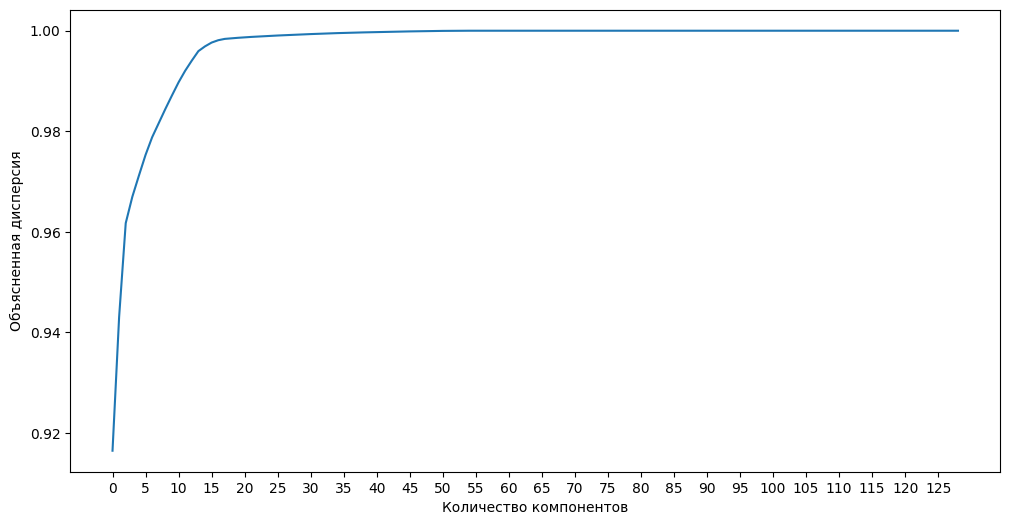

In [ ]:
plt.figure(figsize=(12, 6))  # Устанавливаем размер фигуры

pca = PCA().fit(x_train[selected_features])
n_components = pca.explained_variance_ratio_.shape[0]

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, n_components + 1, step=5))  # Устанавливаем шаг на оси X
plt.xlabel('Количество компонентов')
plt.ylabel('Объясненная дисперсия')
plt.show()

In [ ]:
components = 15
pca = PCA(n_components=components)
x_train_pca = pca.fit_transform(x_train[selected_features])
x_test_pca = pca.transform(x_test[selected_features])
x_val_pca = pca.transform(x_val[selected_features])

test_df_pca = pca.transform(test_df[selected_features])

In [ ]:
x_train_pca.shape, x_test_pca.shape, x_val_pca.shape

((49000, 15), (16800, 15), (4200, 15))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(1, 105),
              'metric': ['manhattan', 'cosine', 'chebyshev']}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(x_train_pca, y_train)

print(grid_search.best_params_)
best_params = grid_search.best_params_

In [ ]:
best_params={'metric': 'manhattan', 'n_neighbors': 102}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(**best_params)
neigh.fit(x_train_pca, y_train)
preds = neigh.predict(x_test_pca)
len(preds)
print('mae ', mean_absolute_error(y_test, preds))
print('accuracy ', accuracy_score(y_test, preds))

mae  1.5173214285714285
accuracy  0.2863095238095238


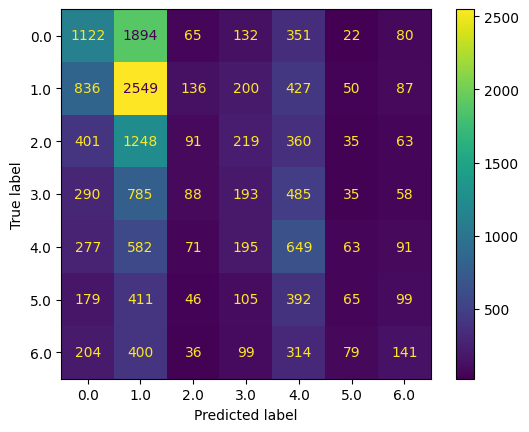

In [ ]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
disp.plot()
plt.show()

In [ ]:
x_train['knn_target'] = neigh.predict(x_train_pca)
x_test['knn_target'] = neigh.predict(x_test_pca)
x_val['knn_target'] = neigh.predict(x_val_pca)
test_df['knn_target'] = neigh.predict(test_df_pca)

In [ ]:
selected_features.append('knn_target')

In [ ]:
x_train.shape, x_test.shape, x_val.shape

((49000, 151), (16800, 151), (4200, 151))

#### Запуск модели

In [ ]:
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.sort(x_train['target'].unique()),
                                       y=x_train['target'])
cw

array([0.65851364, 0.55830276, 1.00850022, 1.24223602, 1.24356014,
       1.83150183, 1.83968463])

In [ ]:
# cw_dict = {0:0.66281602, 1:0.55454329, 2:1.01170689, 3:1.24157503, 4:1.2567325, 5:1.82101977, 6:1.82054616 }

In [ ]:
cw = [0.9, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2]

##### Прогноз всех классов одной моделью

In [ ]:
classifier_model = fit_catboost_classifier(features_train=x_train[selected_features],  target_train=y_train, features_val=x_val[selected_features], target_val=y_val,
                                           params={'learning_rate': 0.01, 'iterations': 5000, 'use_best_model': True, "class_weights": cw, 'eval_metric': 'MultiClass'})
# classifier_model = MLPClassifier(hidden_layer_sizes=(150,), random_state=42, max_iter=2550, solver='adam', activation='relu',
#                                  learning_rate_init=0.01, early_stopping=True, validation_fraction=0.15).fit(pd.concat([x_train, x_val])[selected_features], pd.concat([y_train, y_val]))
# classifier_model = RandomForestClassifier(max_depth=10, random_state=42, class_weight=cw_dict).fit(pd.concat([x_train, x_val])[selected_features], pd.concat([y_train, y_val]))
classifier_model.save_model("classifier_model.model")

0:	learn: 1.9372767	test: 1.9373898	best: 1.9373898 (0)	total: 826ms	remaining: 1h 8m 47s
500:	learn: 1.4616252	test: 1.4779948	best: 1.4779948 (500)	total: 2m 53s	remaining: 25m 54s
1000:	learn: 1.4336831	test: 1.4683442	best: 1.4683439 (999)	total: 5m 37s	remaining: 22m 28s
1500:	learn: 1.4103750	test: 1.4639093	best: 1.4638971 (1496)	total: 8m 10s	remaining: 19m 2s
2000:	learn: 1.3898803	test: 1.4610809	best: 1.4610809 (2000)	total: 10m 44s	remaining: 16m 5s
2500:	learn: 1.3708576	test: 1.4595399	best: 1.4595373 (2496)	total: 13m 19s	remaining: 13m 18s
3000:	learn: 1.3530127	test: 1.4584581	best: 1.4584190 (2927)	total: 15m 53s	remaining: 10m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.458139332
bestIteration = 3265

Shrink model to first 3266 iterations.


In [ ]:
# прогноз и оценка качества модели
predict = classifier_model.predict(x_test[selected_features])
print('mae ', mean_absolute_error(y_test, predict))
print('accuracy ', accuracy_score(y_test, predict))

mae  1.4335714285714285
accuracy  0.33845238095238095


In [ ]:
def get_mentrics_for_class(y, predict):
  df = pd.DataFrame()
  df['real'] = y
  df['predict'] = predict
  df['accuracy'] = df.apply(lambda x: x['real'] == x['predict'], axis=1)
  df['mae'] = df.apply(lambda x: abs(x['real'] - x['predict']), axis=1)
  df = df.groupby('real', as_index=False).agg({'accuracy': ['sum', 'mean'],
                                               'mae': ['mean']})
  print(df)


In [ ]:
get_mentrics_for_class(y_test, predict)

  real accuracy                 mae
            sum      mean      mean
0  0.0     2081  0.567649  0.549373
1  1.0     2718  0.634306  0.427538
2  2.0      169  0.069921  1.240794
3  3.0      152  0.078594  1.813857
4  4.0      456  0.236515  2.207988
5  5.0       63  0.048574  3.100231
6  6.0       47  0.036921  4.283582


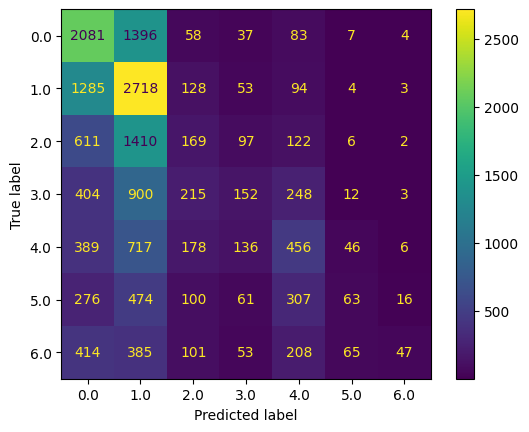

In [ ]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier_model.classes_)
disp.plot()
plt.show()

##### Разбиение на 2 этапа: Предсказываем 0, 1 классы и как 3 класс все остальные, затаем из 3 класса предсказываем 3, 4, 5, 6 классы  **(НЕ ЛУЧШЕЕ РЕШЕНИЕ)**

In [ ]:
# Разбивка на 3 класса и обучение ансамбля
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.decomposition import PCA

x_train_3 = x_train.copy()
x_test_3 = x_test.copy()
x_val_3 = x_val.copy()

max_class_group = 1.0

x_train_3['new_target_class'] = x_train['target'].apply(lambda x: x if x <= max_class_group else max_class_group)
x_test_3['new_target_class'] = x_test['target'].apply(lambda x: x if x <= max_class_group else max_class_group)
x_val_3['new_target_class'] = x_val['target'].apply(lambda x: x if x <= max_class_group else max_class_group)

# alpha = x_train_3.groupby(by=['new_target_class']).agg({'client_num': 'count'})
# alpha['alpha'] = alpha['client_num'].apply(lambda x: alpha['client_num'].max()/x)

# print(alpha)

# x_train_3 = pd.concat([x_train_3[x_train_3['new_target_class']==0.0].sample(frac=alpha.loc[0.0]['alpha'], replace=True, random_state=42),
#                      x_train_3[x_train_3['new_target_class']==1.0].sample(frac=alpha.loc[1.0]['alpha'], replace=True, random_state=42)])


# "class_weights": [2.8, 0.995]
classifier_model1 = fit_catboost_classifier(features_train=x_train_3[selected_features],  target_train=x_train_3['new_target_class'].astype(int), features_val=x_val_3[selected_features], target_val=x_val_3['new_target_class'].astype(int),
                                           params={'learning_rate': 0.0001, 'iterations': 5000, 'use_best_model': True, "class_weights": [2.8, 0.995],  'loss_function': 'Logloss', 'eval_metric': 'AUC'})
predict = classifier_model1.predict(x_test_3[selected_features])


# components = 15
# pca = PCA(n_components=components)
# x_train_pca = pca.fit_transform(x_train_3[selected_features])
# x_test_pca = pca.transform(x_test_3[selected_features])
# x_val_pca = pca.transform(x_val_3[selected_features])

# neigh = KNeighborsClassifier(**{'metric': 'cosine', 'n_neighbors': 20, 'weights': 'uniform'}) # metric='manhattan' cosine chebyshev
# neigh.fit(x_train_pca, x_train_3['new_target_class'])
# predict = neigh.predict(x_test_pca)

# predict = scaler_y.inverse_transform(predict.reshape(-1, 1)).ravel()
# y_test = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
print('mae ', mean_absolute_error(x_test_3['new_target_class'], predict))
print('accuracy ', accuracy_score(x_test_3['new_target_class'], predict))

# test_df['predict_1_2'] = classifier_model1.predict(test_df[selected_features])

0:	test: 0.7103380	best: 0.7103380 (0)	total: 63.9ms	remaining: 5m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7262243607
bestIteration = 29

Shrink model to first 30 iterations.
mae  0.30041666666666667
accuracy  0.6995833333333333


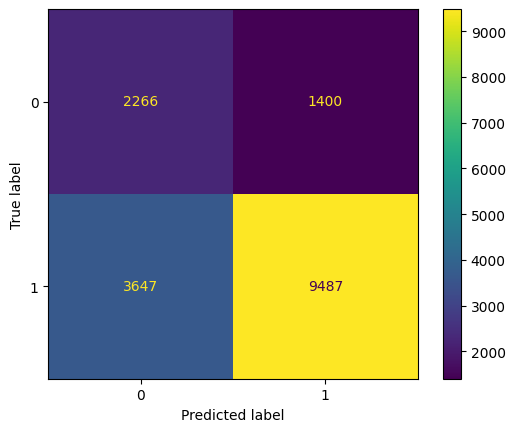

In [ ]:
cm = confusion_matrix(x_test_3['new_target_class'], predict)
# cm = confusion_matrix(x_test_3['target'], x_test_3['predict'])
# classes = [0.0,1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
classes = []
for i in range(int(max_class_group) + 1):
  classes.append(i)
# classes = classifier_model.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()

In [ ]:
cw2 = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.sort(x_train_3[x_train_3['target'] >= 1.0]['target'].unique()),
                                       y=x_train_3[x_train_3['target'] >= 1.0]['target'])
cw2

array([0.51004945, 0.92133698, 1.13487134, 1.13608101, 1.67320774,
       1.68068331])

In [ ]:
from sklearn.utils import class_weight
# x_train_3['new_target_class'] = x_train['target'].apply(lambda x: x if x in [0.0, 1.0, 2.0] else 2.0)
x_test_3['predict_1_2'] = classifier_model1.predict(x_test_3[selected_features])
x_test_all = x_test_3[x_test_3['predict_1_2'] == 1.0]
# x_val_3['new_target_class'] =classifier_model.predict(x_test_3[selected_features])

# cw2 = class_weight.compute_class_weight(class_weight='balanced',
#                                        classes=np.sort(x_train_3[x_train_3['target'] >= 1.0]['target'].unique()),
#                                        y=x_train_3[x_train_3['target'] >= 1.0]['target'])

# classifier_model = fit_catboost_classifier(features_train=x_train_3[x_train_3['target'] >= max_class_group][selected_features],  target_train=x_train_3[x_train_3['target'] >= max_class_group]['target'],
#                                            features_val=x_val_3[x_val_3['target'] >= max_class_group][selected_features], target_val=x_val_3[x_val_3['target'] >= max_class_group]['target'],
#                                            params={'learning_rate': 0.01, 'iterations': 5000, 'use_best_model': True, "class_weights": [1.8, 1.55, 1.5, 0.95, 0.8, 0.7], 'eval_metric': 'TotalF1'})
# # classifier_model.save_model("classifier_model_pca.model")
# predict = classifier_model.predict(x_test_all[selected_features])


components = 15
pca = PCA(n_components=components)
x_train_pca = pca.fit_transform(x_train_3[x_train_3['target'] >= max_class_group][selected_features])
x_test_pca = pca.transform(x_test_all[selected_features])
x_val_pca = pca.transform(x_val_3[x_val_3['target'] >= max_class_group][selected_features])

# neigh = KNeighborsClassifier(**{'metric': 'manhattan', 'n_neighbors': 102, 'weights': 'uniform'}) # metric='manhattan' cosine chebyshev
# neigh.fit(x_train_pca, x_train_3[x_train_3['target'] >= max_class_group]['target'])
# predict = neigh.predict(x_test_pca)

classifier_model = fit_catboost_classifier(features_train=x_train_pca,  target_train=x_train_3[x_train_3['target'] >= max_class_group]['target'],
                                           features_val=x_val_pca, target_val=x_val_3[x_val_3['target'] >= max_class_group]['target'],
                                           params={'learning_rate': 0.01, 'iterations': 5000, 'use_best_model': True, "class_weights": [1.8, 1.2, 1.0, 0.95, 0.9, 0.9], 'eval_metric': 'MultiClass'})
# classifier_model.save_model("classifier_model_pca.model")
predict = classifier_model.predict(x_test_pca)



x_test_all['predict_all'] = predict


# predict = scaler_y.inverse_transform(predict.reshape(-1, 1)).ravel()
# y_test = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
print('mae ', mean_absolute_error(x_test_all['target'], predict))
print('accuracy ', accuracy_score(x_test_all['target'], predict))

if 'predict_all' in x_test_3.columns.values:
  x_test_3 = x_test_3.drop(columns=['predict_all'])

x_test_3 = x_test_3.merge(x_test_all[['client_num', 'predict_all']], on='client_num', how='left')

x_test_3['predict'] = x_test_3.apply(lambda x: x['predict_all'] if x['predict_1_2'] == max_class_group else x['predict_1_2'] , axis=1)

print('\n Все классы')
print('mae ', mean_absolute_error(y_test, x_test_3['predict']))
print('accuracy ', accuracy_score(y_test, x_test_3['predict']))


# test_df_all = test_df[test_df['predict_1_2'] == 2.0]
# test_df_all['predict_all'] = classifier_model.predict(test_df_all[selected_features])
# if 'predict_all' in test_df.columns.values:
#   test_df = test_df.drop(columns=['predict_all'])
# test_df = test_df.merge(test_df_all[['client_num', 'predict_all']], on='client_num', how='left')

# test_df['target'] = test_df.apply(lambda x: x['predict_all'] if x['predict_1_2'] == 2.0 else x['predict_1_2'] , axis=1)

0:	learn: 1.7832655	test: 1.7829570	best: 1.7829570 (0)	total: 55.6ms	remaining: 4m 37s
500:	learn: 1.4166675	test: 1.4212164	best: 1.4212164 (500)	total: 31.2s	remaining: 4m 40s
1000:	learn: 1.3938244	test: 1.4168181	best: 1.4168181 (1000)	total: 59.8s	remaining: 3m 59s
1500:	learn: 1.3741724	test: 1.4149670	best: 1.4149670 (1500)	total: 1m 27s	remaining: 3m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.414656103
bestIteration = 1632

Shrink model to first 1633 iterations.
mae  1.6967943418756315
accuracy  0.24974740516211996

 Все классы
mae  1.5813095238095238
accuracy  0.2967261904761905


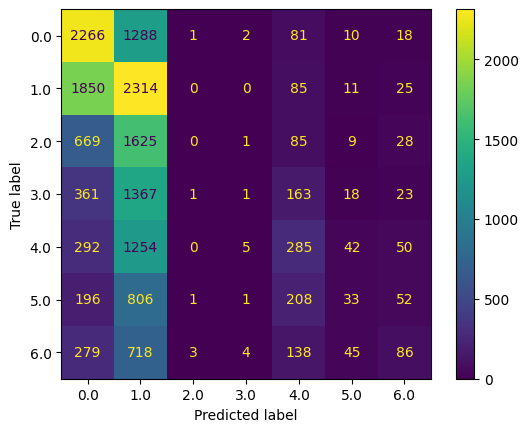

In [ ]:
cm = confusion_matrix(x_test_3['target'], x_test_3['predict'])
classes = [0.0,1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()

##### Ансамбль **(НЕ ЛУЧШЕЕ РЕШЕНИЕ)**

In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

cw = [0.9, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2]
cw_dict = {}
for class_i, w in zip([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], cw):
  cw_dict[class_i] = w

params={'learning_rate': 0.01, 'iterations': 1000, "class_weights": cw}
# fit_catboost_classifier(features_train=x_train[selected_features],  target_train=y_train, features_val=x_val[selected_features], target_val=y_val)
catboost = CatBoostClassifier(**params, random_seed=42, verbose=0, task_type="CPU", eval_metric= 'MultiClass')
xgboost = XGBClassifier(**params, random_seed=42, verbose=0)
lgbm = LGBMClassifier(learning_rate= 0.01,  class_weight=cw_dict, random_seed=42, verbose=0)
# forest = RandomForestClassifier(max_depth=3, random_state=42, class_weight=cw_dict)
neigh = KNeighborsClassifier(**{'metric': 'manhattan', 'n_neighbors': 102, 'weights': 'uniform'})
# tree = DecisionTreeClassifier(random_state=42)

ensemble = VotingClassifier(estimators=[
    ('catboost', catboost),
    ('xgboost', xgboost),
    ('lgbm', lgbm),
    # ('forest', forest),
    ('neigh', neigh),
    # ('tree', tree)
], voting='soft')

# ensemble.fit(x_train[selected_features],  y_train)
ensemble.fit(x_train_pca,  y_train)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7cdd85dc0490>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weights=[0.9, 0.8, 0.7, 0.5,
                                                           0.4, 0.3, 0.2],
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_me...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight={0.0: 0.9, 1.0: 0.8,
                                                           2.0: 0.7, 3.0: 0.5,
                                                           4.0: 0.4, 5.0: 0.3,
                                                           6.0: 0.2},
                                             learning_rate=0.01, random_seed=42,
                                             verbose=0)),
                             ('neigh',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=102))],
                 voting='soft')

mae  1.6148809523809524
accuracy  0.2889285714285714


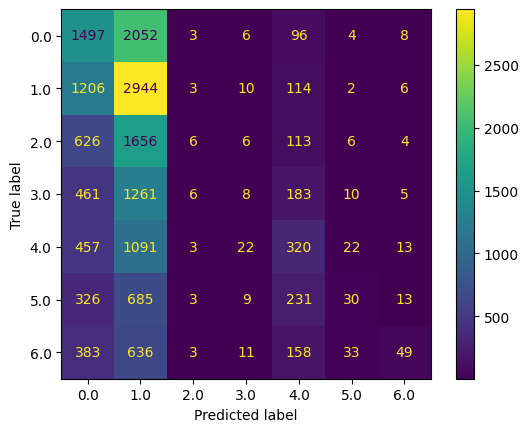

In [ ]:
# predict = ensemble.predict(x_test[selected_features])
predict = ensemble.predict(x_test_pca)
print('mae ', mean_absolute_error(y_test, predict))
print('accuracy ', accuracy_score(y_test, predict))
classes = [0.0,1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()

### Создание csv файла

In [ ]:
# На всем наборе данных
classifier_model_all = fit_catboost_classifier(features_train=train_df[selected_features],  target_train=train_df['target'])
classifier_model_all.save_model("classifier_model_all.model")

0:	learn: 1.9413813	total: 1.18s	remaining: 50m 16s
500:	learn: 1.6599052	total: 3m 44s	remaining: 15m 16s
1000:	learn: 1.6360106	total: 7m 4s	remaining: 10m 56s
1500:	learn: 1.6149709	total: 10m 18s	remaining: 7m 11s
2000:	learn: 1.5961609	total: 13m 28s	remaining: 3m 41s
2500:	learn: 1.5795067	total: 16m 38s	remaining: 19.6s
2549:	learn: 1.5778940	total: 16m 58s	remaining: 0us


In [ ]:
predict_test = classifier_model.predict(test_df[selected_features])
# predict_test = ensemble.predict(test_df[selected_features])
# predict_test = ensemble.predict(test_df_pca)
test_df['target'] = predict_test
test_df['target'] = test_df['target'].astype(int)
test_df

In [ ]:
test_df[['client_num', 'target']].to_csv('prediction.csv', index=False)